<a href="https://www.kaggle.com/code/mariuszcha/paddy-disease?scriptVersionId=131634494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Rice (Oryza sativa) is one of the staple foods worldwide. Paddy, the raw grain before removal of husk, is cultivated in tropical climates, mainly in Asian countries. Paddy cultivation requires consistent supervision because several diseases and pests might affect the paddy crops, leading to up to 70% yield loss. Expert supervision is usually necessary to mitigate these diseases and prevent crop loss. With the limited availability of crop protection experts, manual disease diagnosis is tedious and expensive. Thus, it is increasingly important to automate the disease identification process by leveraging computer vision-based techniques that achieved promising results in various domains.

The main objective of this competition is to develop a machine or deep learning-based model to classify the given paddy leaf images accurately. To do that we will use FastAI.
My approach is mostly based on Jeremy Howard's notebook, because it is kinda difficult to improve perfection. I wanted to consolidate my knowledge about Image Classification models and resizing/transforming methods to data.

In [1]:
# It basically imports everything - PyTorch with FastAI, Numpy, Pandas...
from fastai.vision.all import *

# Paths to our data and to submission file which is template
train_path = '/kaggle/input/paddy-disease-classification/train_images'
test_path = '/kaggle/input/paddy-disease-classification/test_images'
submission = pd.read_csv('/kaggle/input/paddy-disease-classification/sample_submission.csv')

**Here we perform simple data exploration - we checked whether all train pictures have the same size. If not, fastAI will not be able to create batches.**

(480, 640)    10403
(640, 480)        4
dtype: int64


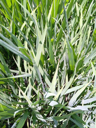

In [2]:
train_images = get_image_files(train_path)
img = PILImage.create(train_images[0])

sizes = [PILImage.create(i).size for i in train_images]
print(pd.Series(sizes).value_counts())

img.to_thumb(128)

As evident from the table above, there are four images with varying sizes. One possible solution to address this issue would be to transpose the images, as they have the same sizes but in different axes. However, we will resolve the problem by resizing all the pictures. 
We will also resize each picture to smaller images. By resizing our training set, we can determine appropriate parameters for our architecture minimalizing - at the same time - time of training. Once we identify the best model, we will employ unscaled, pristine data for further analysis.

In [3]:
# Resizing to speed up iterating on Kaggle.
resized_train_path = Path('resized_train_images')
resize_images(train_path, dest=resized_train_path, max_size=256, recurse=True)

# As we can see, images are resized from 640 to 256 and another dimension is scaled to keep proportions...
print(PILImage.create(get_image_files(resized_train_path)[0]).size)

(192, 256)


### Modifying transformers and architecture used in model:

In [4]:
data = train_path # resized_train_path
architecture = 'resnet26d' # convnext_small_in22k
item_tf = Resize(size=(480, 360), method='crop') # (480, 360) (192,256)
batch_tf = aug_transforms(size=(256,192), min_scale=0.75) # (256,192) (171,128)
epoch = 4
lr = 0.01

# We use Gradient Accumulation as our callback to improve stability of our model
accum = 3
batch = 64

dls = ImageDataLoaders.from_folder(data, valid_pct=0.2,
    item_tfms=item_tf, batch_tfms=batch_tf, bs=batch//accum)
cbs = GradientAccumulation(batch) if accum else []
learn = vision_learner(dls, architecture, metrics=error_rate, cbs=cbs).to_fp16()
learn.fine_tune(epoch, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.585349,0.999172,0.333493,01:41


epoch,train_loss,valid_loss,error_rate,time
0,1.134991,0.622520,0.198943,01:45
1,0.846304,0.458005,0.145123,01:46
2,0.546809,0.317976,0.104757,01:45
3,0.460175,0.273390,0.082172,01:44


We are using already pretrained model. We also use .to_fp16() to increase the speed of tuning. It enables tensor cores feature in our GPU.
We can also check whether our model predict better when we use TTA. Basically it is process of predicting on quite modified validation set. Colors could be modified or dimensions flipped...

In [5]:
# Assigning validation set to valid variable
valid = learn.dls.valid

preds,targs = learn.get_preds(dl=valid)
print('Error rate without TTA: ',error_rate(preds, targs))

tta_preds,_ = learn.tta(dl=valid)
print('Error rate with TTA: ',error_rate(tta_preds, targs))

Error rate without TTA:  TensorBase(0.0822)


Error rate with TTA:  TensorBase(0.0692)


We can notice slight improvement with TTA. It is worthy to use that in our test predictions.

In [6]:
# Loading test images from path and transforming them to the same dimension as train data
test_images = get_image_files(test_path).sorted()
test_dl = dls.test_dl(test_images)

# No TTA solution; We use with_decoded param to obtain indices
#_,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

# TTA
predictions,_= learn.tta(dl=test_dl)
c = [i.argmax().item() for i in predictions]

Here - we predict on our final, test set and verify model by submission.

In [7]:
mapping = dict(enumerate(dls.vocab))
#results = pd.Series(idxs.numpy()).map(mapping)
results = pd.Series(c).map(mapping)

pd.DataFrame({'image_id':submission['image_id'],'label':results}).to_csv('submission.csv', index=False)

In [8]:
#learn.dls.train.show_batch(max_n=6, unique=True)
#dls.show_batch(max_n=3)
#learn.lr_find()